In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

In [23]:
from sklearn.ensemble import RandomForestRegressor
## visualize one of the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [24]:
## hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
tuning = {
    'max_depth': [7,10,13,15,17,21],
    'max_features': [5,7,10,15,20,30],
    'min_samples_split': [2,5,7,10],
    'n_estimators': [20,50,80,100]
}

In [3]:
meta = pd.read_csv("..//data//potatometadata_forClaudia.csv")
taxa = pd.read_csv("..//data//potatorar_forsubmission.csv")
taxa.columns.values[0] = "FieldID"
taxa = taxa.rename(columns = {'FieldID':'FieldID'})

# Preprocessing

In [4]:
import Utils
importlib.reload(Utils) ## update the Utils library

<module 'Utils' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\Utils.py'>

In [44]:
import ML_model as ml
importlib.reload(ml)

<module 'ML_model' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\ML_model.py'>

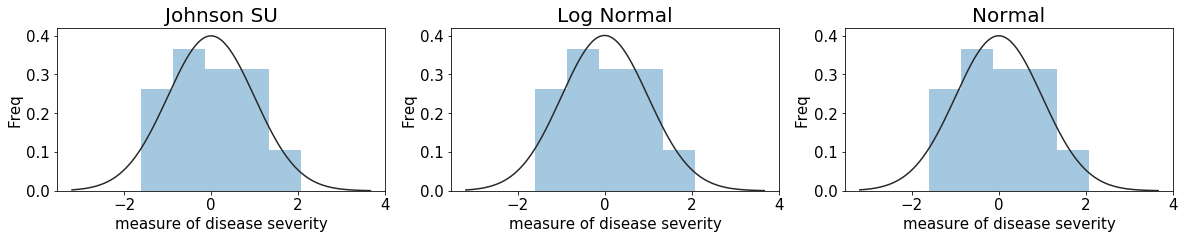

In [6]:
yt_disease, gamma, eta, epsilon, lbda = Utils.johnson_transform(meta.diffCSscore)
Utils.check_dist(yt_disease, xlab="measure of disease severity")

In [7]:
trans_param = {gamma, eta, epsilon, lbda}
trans_param

{-7.73291132432589,
 -0.9431298912958859,
 0.07409141934956123,
 1.8920552756904958}

In [8]:
y = meta.diffCSscore
y

0     1.280556
1     0.762103
2     1.089286
3     3.208333
4     2.450000
5     1.646429
6     2.327381
7     0.871230
8     3.471667
9     2.305833
10    0.900000
11    1.614583
12    5.665179
13    3.741000
14    1.375000
15    1.678000
16    0.833000
17    0.987000
18    0.000000
19    0.000000
20    1.010000
21    2.500000
22    0.000000
23    0.000000
24    1.435000
25    0.000000
Name: diffCSscore, dtype: float64

In [9]:
yt_disease

0     0.015142
1    -0.486763
2    -0.154928
3     1.195968
4     0.814400
5     0.303205
6     0.744778
7    -0.369501
8     1.312314
9     0.732274
10   -0.339759
11    0.279803
12    2.075431
13    1.424344
14    0.093800
15    0.326124
16   -0.409760
17   -0.252561
18   -1.605319
19   -1.605319
20   -0.230164
21    0.842071
22   -1.605319
23   -1.605319
24    0.142125
25   -1.605319
Name: diffCSscore, dtype: float64

## Using only meta data

In [10]:
# drop non-numeric column
meta_clean = meta.drop(['field name', 'diffCSscore'], axis=1)
# In the new field, experiment conducted in 2015 is labeled as 0 whereas in 2017 as 1
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2015, 0)
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2017, 1)
# drop all column related to yield
yld_list = ['Mean.Control.Microbe', 'Mean.LowN.Microbe', 'varCtub', 'varNtub', 'invVar_Ctub',
           'invVar_Ntub', 'Std.Err.Mean.Control.Microbe', 'Std.Err.Mean.LowN.Microbe', ]
disease_unwanted = ['varCSscore', 'invVar_Csscore', 'seCSscore']
meta_clean = meta_clean.drop(yld_list, axis=1)
meta_clean = meta_clean.drop(disease_unwanted, axis=1)
meta_clean_2 = meta_clean.set_index('FieldID')

In [11]:
# Pay attention here. yt has the index of field id, whereas yt_disease is just a series of number starting at 0
yt = yt_disease.copy()
yt.index = meta_clean_2.index  
yt

FieldID
1     0.015142
2    -0.486763
3    -0.154928
4     1.195968
5     0.814400
6     0.303205
7     0.744778
8    -0.369501
9     1.312314
10    0.732274
11   -0.339759
12    0.279803
13    2.075431
27    1.424344
28    0.093800
29    0.326124
30   -0.409760
31   -0.252561
32   -1.605319
33   -1.605319
36   -0.230164
37    0.842071
38   -1.605319
40   -1.605319
41    0.142125
42   -1.605319
Name: diffCSscore, dtype: float64

In [12]:
meta_clean_2_unnormalized = meta_clean_2.copy()
meta_clean_2, mu_meta, sd_meta = Utils.normalization(meta_clean_2)
xtrain_meta_d, xval_meta_d, ytrain_meta_d, yval_meta_d = train_test_split(meta_clean_2, yt, test_size = 0.2, random_state = 1)

ytrain_d_orig = Utils.johnson_inverse(ytrain_meta_d, gamma, eta, epsilon, lbda)
yval_d_orig = Utils.johnson_inverse(yval_meta_d, gamma, eta, epsilon, lbda)

In [13]:
print(xval_meta_d.iloc[:, :4], end="\n\n")
print(yval_meta_d)

         Experiment  claderich0.1  cladediv0.1  claderich0.15
FieldID                                                      
32         0.980581      1.939437     1.238745       1.882767
27         0.980581      1.453018    -0.000250       1.219461
31         0.980581      1.290879     0.828124       1.020470
4         -0.980581     -0.979072    -1.608700      -1.035777
38         0.980581      1.453018     1.249896       0.887809
11        -0.980581     -1.303351    -1.145145      -0.969446

FieldID
32   -1.605319
27    1.424344
31   -0.252561
4     1.195968
38   -1.605319
11   -0.339759
Name: diffCSscore, dtype: float64


## Using only taxa data

In [14]:
taxa_clean = taxa.loc[:, (taxa != 0).any(axis=0)]  # drop columns contain only 0
print(taxa_clean.shape)

taxa_clean_2 = taxa_clean.set_index('FieldID')

taxa_clean_2_unnormalized = taxa_clean_2.copy()
X_taxa, mu_taxa, sd_taxa = Utils.normalization(taxa_clean_2)
X_taxa = pd.concat([meta_clean['Experiment'], X_taxa.reset_index()], axis=1)
X_taxa = X_taxa.set_index('FieldID')
print(X_taxa.shape)

xtrain_taxa_d, xval_taxa_d, ytrain_taxa_d, yval_taxa_d = train_test_split(X_taxa, yt, test_size = 0.2, random_state = 1)

(26, 9892)
(26, 9892)


In [15]:
print(xval_taxa_d.iloc[:, :4], end="\n\n")
print(yval_taxa_d)

         Experiment  X.f60d1b84853b19fa59e9f6d208e16d96  \
FieldID                                                   
32                1                           -0.202122   
27                1                           -0.202122   
31                1                           -0.202122   
4                 0                           -0.202122   
38                1                           -0.202122   
11                0                           -0.202122   

         X.143dd5eba65cad20a08627268e42e7da  \
FieldID                                       
32                                -0.196116   
27                                -0.196116   
31                                -0.196116   
4                                 -0.196116   
38                                -0.196116   
11                                -0.196116   

         X.1d83379743c4c48f1b55deb99f006f2f  
FieldID                                      
32                                -0.196116  
27          

## Combine two data set

In [16]:
clean = pd.concat([meta_clean_2_unnormalized.drop(['Experiment'], axis=1), taxa_clean_2_unnormalized], axis=1)
total, mu_total, sd_total = Utils.normalization(clean)
total = pd.concat([X_taxa.Experiment, total], axis=1)

xtrain_d, xval_d, ytrain_d, yval_d = train_test_split(total, yt, test_size = 0.2, random_state = 1)

# Base Model Prediction

## Using only meta data

### XGBoost

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1624599056068392
RMSE for validation set: 0.28672707146660115


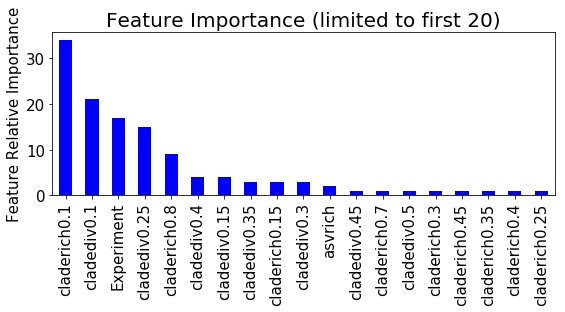

In [32]:
xgb_meta_1 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_pred1, val_pred1, top1 = ml.xgb_fit(xgb_meta_1, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1624599056068392
RMSE for validation set: 0.28672707146660115


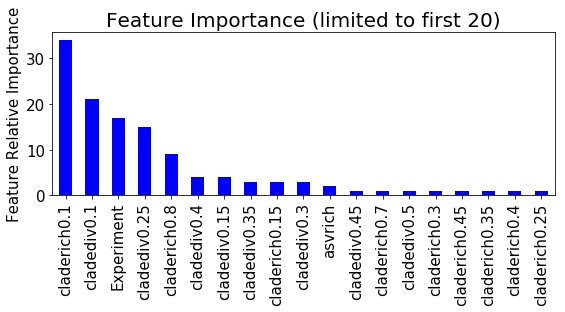

In [33]:
xgb_meta_2 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_pred2, val_pred2, top2 = ml.xgb_fit(xgb_meta_2, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.11447707684580254
RMSE for validation set: 0.28468238332380613


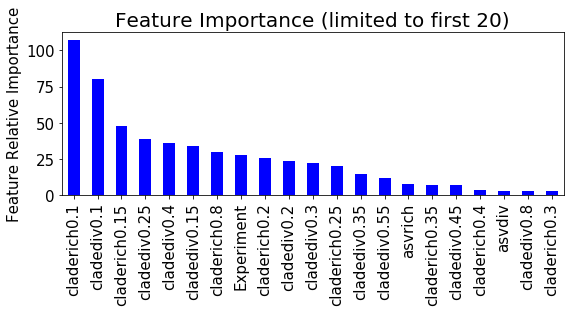

In [34]:
xgb_meta_3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_pred3, val_pred3, top3 = ml.xgb_fit(xgb_meta_3, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1445008302627082
RMSE for validation set: 0.27824077113433654


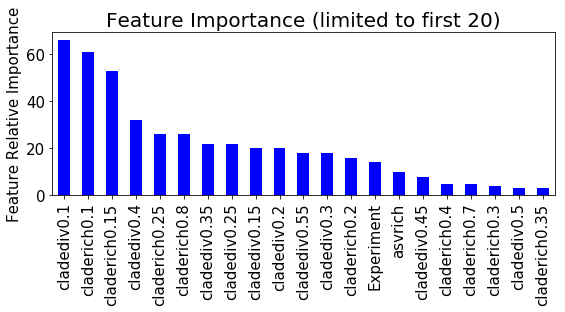

In [38]:
xgb_meta_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=2.5,
    seed=2)
train_pred4, val_pred4, top4 = ml.xgb_fit(xgb_meta_4, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.17021322209689327
RMSE for validation set: 0.28139722689751767


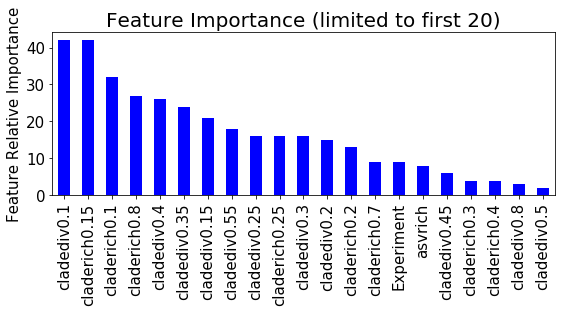

In [36]:
xgb_meta_5 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_pred5, val_pred5, top5 = ml.xgb_fit(xgb_meta_5, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.19110632051742477
RMSE for validation set: 0.2909368467680982


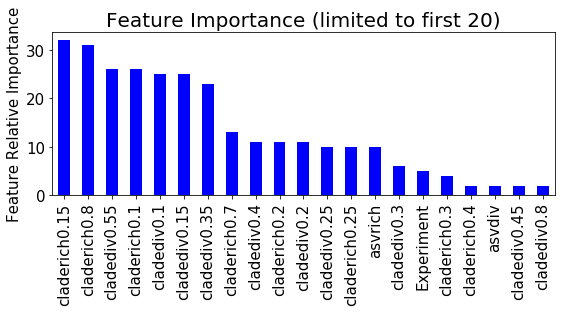

In [37]:
xgb_meta_6 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_pred6, val_pred6, top6 = ml.xgb_fit(xgb_meta_6, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param)

The best comb for hyperparameter seems to be  
xgb_meta_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=2.5,
    seed=2)  
    
RMSE for traning set: 0.1445008302627082
RMSE for validation set: 0.27824077113433654

### Random Forest

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.08602709279226231
RMSE for validation set: 0.2399403026489487


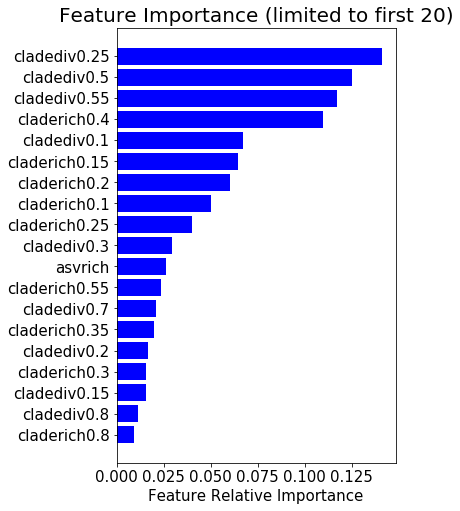

In [45]:
rf7 = RandomForestRegressor(random_state=2)
train_pred7, val_pred7, importances7, rf7 = \
    ml.rf_fit(rf7, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param, fs=(5, 8))

This seems to be the best model. 

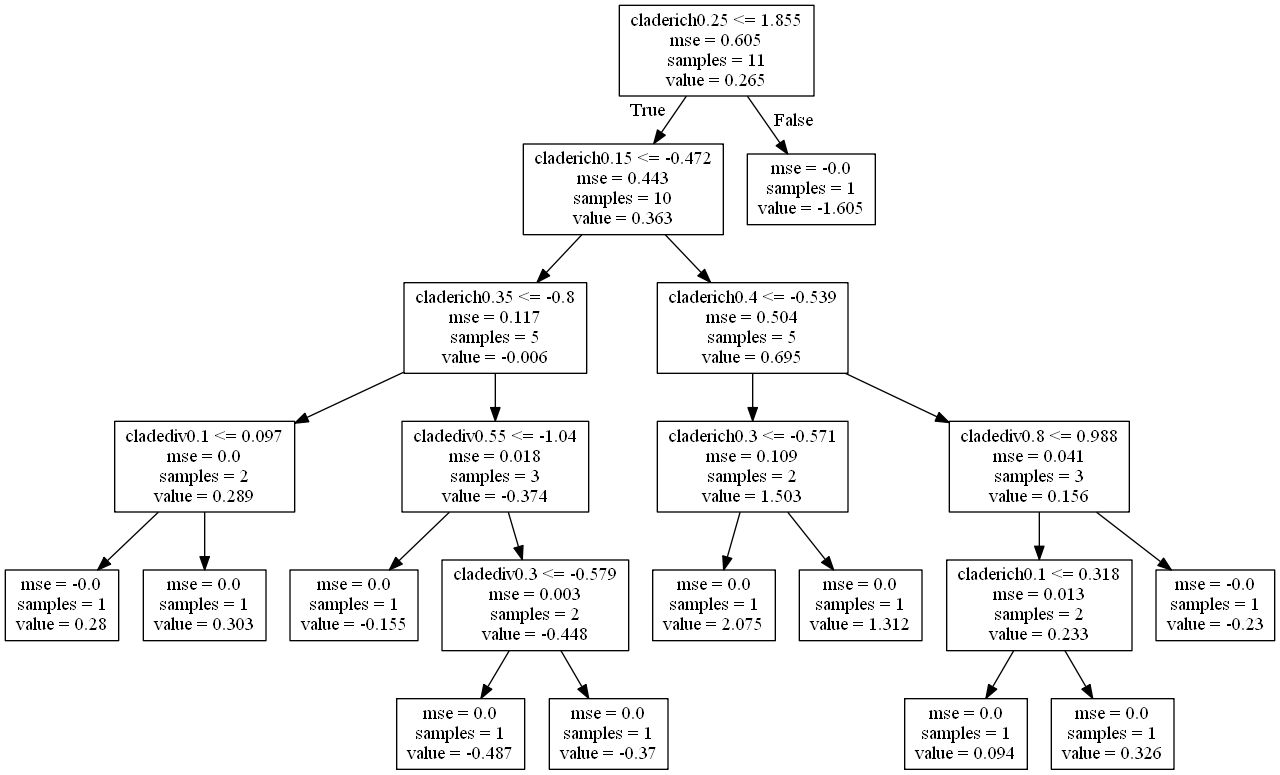

In [51]:
## visualize one of the tree
dot_data = StringIO()
es = rf7.estimators_[0]
export_graphviz(es, out_file=dot_data, feature_names=xtrain_meta_d.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [41]:
train_pred_rs7, val_pred_rs7, estimators_rs7, param_rs7 = \
    ml.random_search(rf7, tuning, xtrain_meta_d, ytrain_meta_d, xval_meta_d, yval_meta_d, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.14032390782065518
RMSE for validation set: 0.26528787443494817


In [42]:
param_rs7

{'n_estimators': 100,
 'min_samples_split': 7,
 'max_features': 10,
 'max_depth': 15}

## Using only taxa data

### XGBoost

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.0034457387244919272
RMSE for validation set: 0.31924770979985023


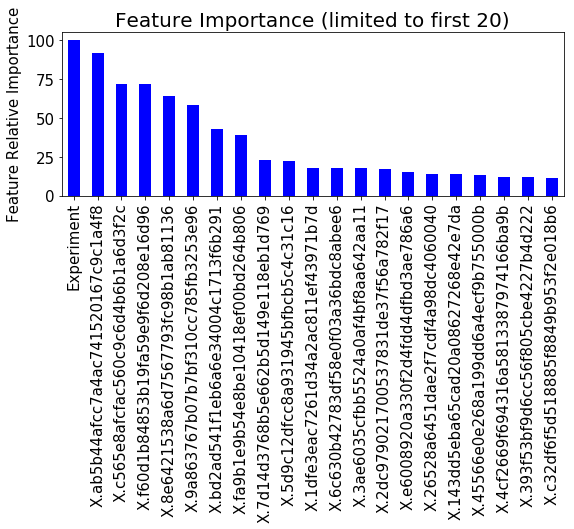

In [52]:
xgb_taxa_1 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_taxa_pred1, val_taxa_pred1, top_taxa_1 = \
    ml.xgb_fit(xgb_taxa_1, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.008226956399153012
RMSE for validation set: 0.31780741744588414


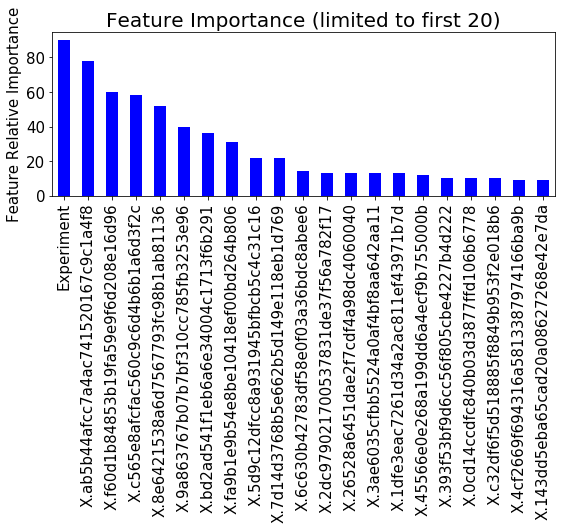

In [53]:
xgb_taxa_2 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_taxa_pred2, val_taxa_pred2, top_taxa_2 = \
    ml.xgb_fit(xgb_taxa_2, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.09717647426182921
RMSE for validation set: 0.31249391751142175


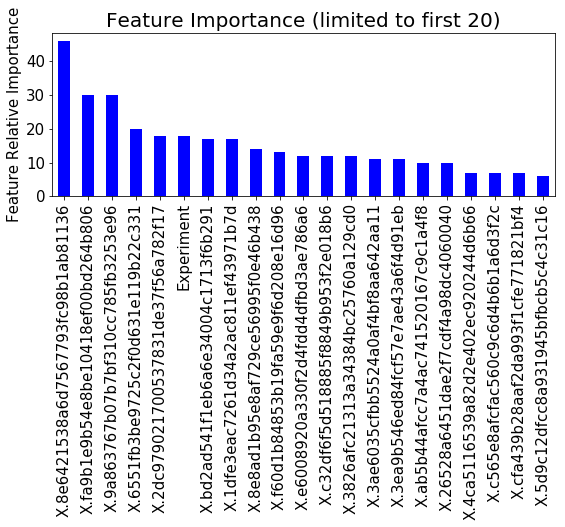

In [55]:
xgb_taxa_3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_taxa_pred3, val_taxa_pred3, top_taxa_3 = \
    ml.xgb_fit(xgb_taxa_3, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.12420061419922221
RMSE for validation set: 0.3065574892553363


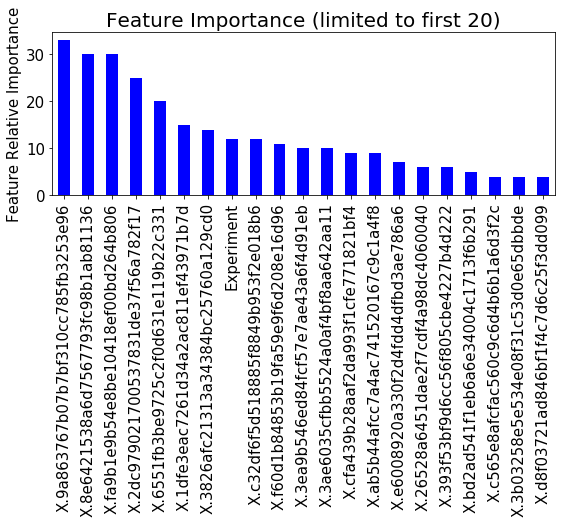

In [56]:
xgb_taxa_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=2.5,
    seed=2)
train_taxa_pred4, val_taxa_pred4, top_taxa_4 = \
    ml.xgb_fit(xgb_taxa_4, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.14874419558402227
RMSE for validation set: 0.3083251513413946


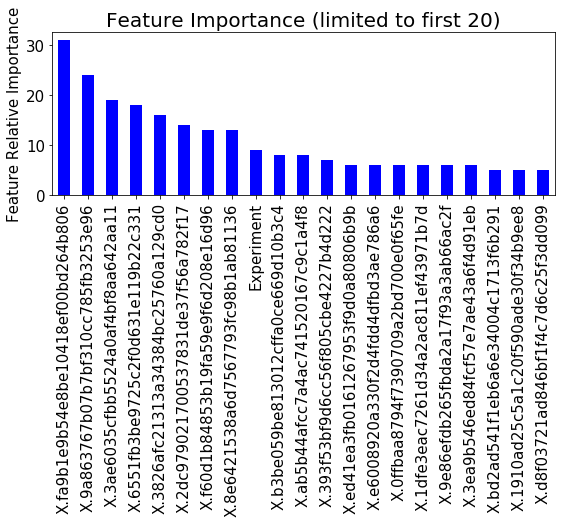

In [58]:
xgb_taxa_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_taxa_pred4, val_taxa_pred4, top_taxa_4 = \
    ml.xgb_fit(xgb_taxa_4, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param)

### Random Forest

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.08897516959103315
RMSE for validation set: 0.2780385325536178


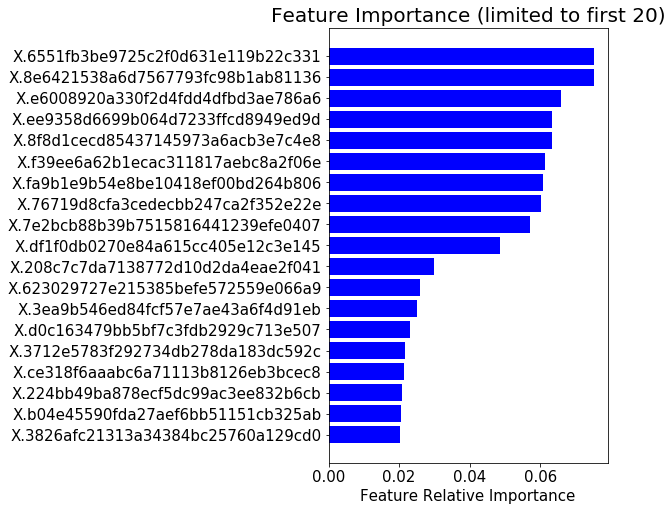

In [59]:
rf_taxa_5 = RandomForestRegressor(random_state=2)
train_taxa_pred5, val_taxa_pred5, importances5, rf_taxa_5 = \
    ml.rf_fit(rf_taxa_5, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param, fs=(5, 8))

In [60]:
train_taxa_pred_rs5, val_taxa_pred_rs5, estimators_taxa_rs5, param_taxa_rs5 = \
    ml.random_search(rf_taxa_5, tuning, xtrain_taxa_d, ytrain_taxa_d, xval_taxa_d, yval_taxa_d, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.10558380166195103
RMSE for validation set: 0.2800089927364571


Still worse than the best score usign only meta data

## Using Both meta and taxa data

### XGBoost

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.008770305177133819
RMSE for validation set: 0.3334740009285186


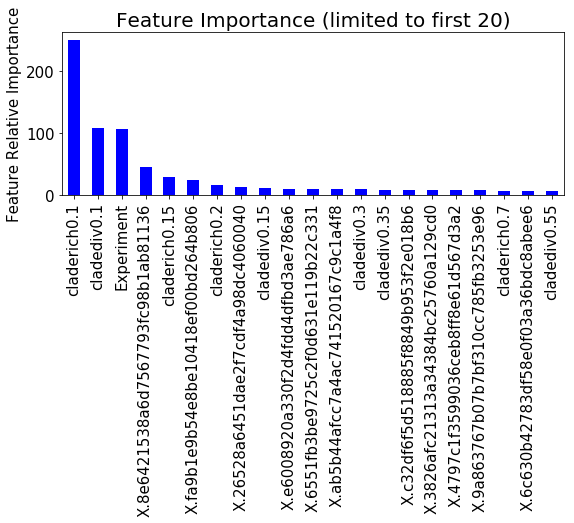

In [63]:
xgb_comb_1 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_comb_pred1, val_comb_pred1, top_comb_1 = \
    ml.xgb_fit(xgb_comb_1, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.06356203239839986
RMSE for validation set: 0.3166542694406516


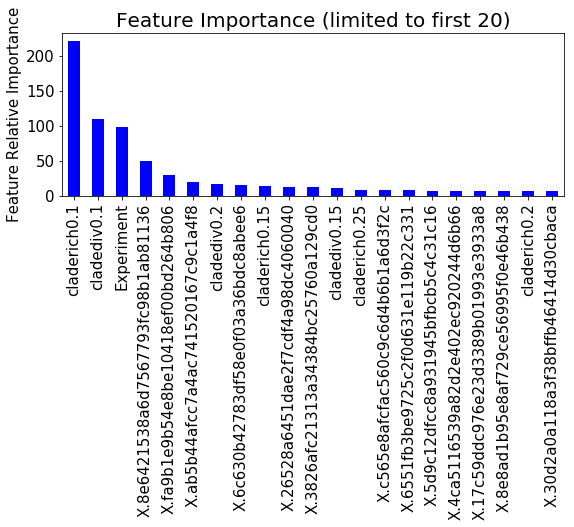

In [64]:
xgb_comb_2 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_comb_pred2, val_comb_pred2, top_comb_2 = \
    ml.xgb_fit(xgb_comb_2, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.09785814892448245
RMSE for validation set: 0.31959073680178596


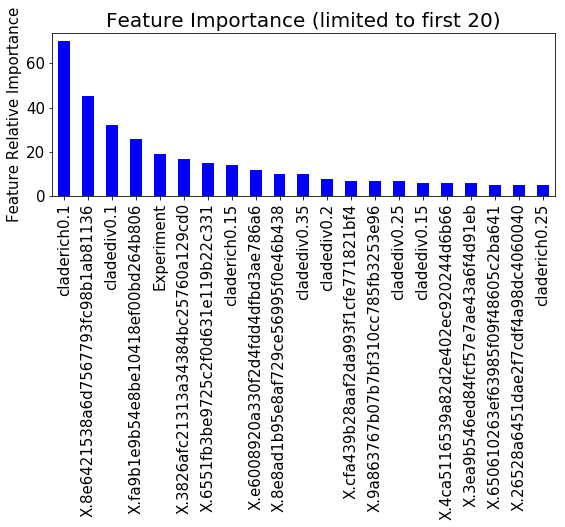

In [65]:
xgb_comb_3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_comb_pred3, val_comb_pred3, top_comb_3 = \
    ml.xgb_fit(xgb_comb_3, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.14940858295334294
RMSE for validation set: 0.3044996655638066


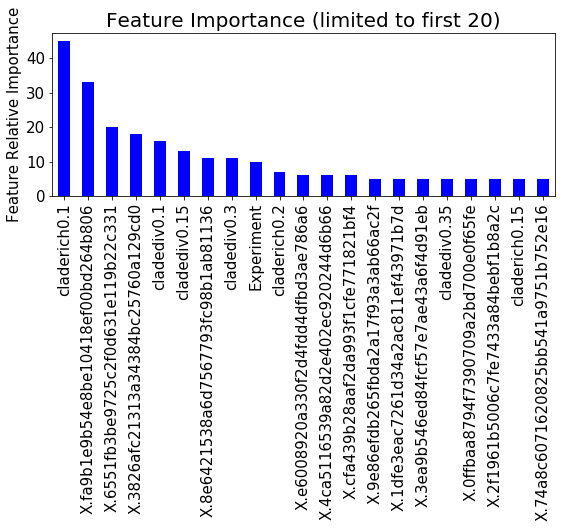

In [66]:
xgb_comb_4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_comb_pred4, val_comb_pred4, top_comb_4 = \
    ml.xgb_fit(xgb_comb_4, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param)

### Random Forest

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.08589698926071102
RMSE for validation set: 0.3525465688545939


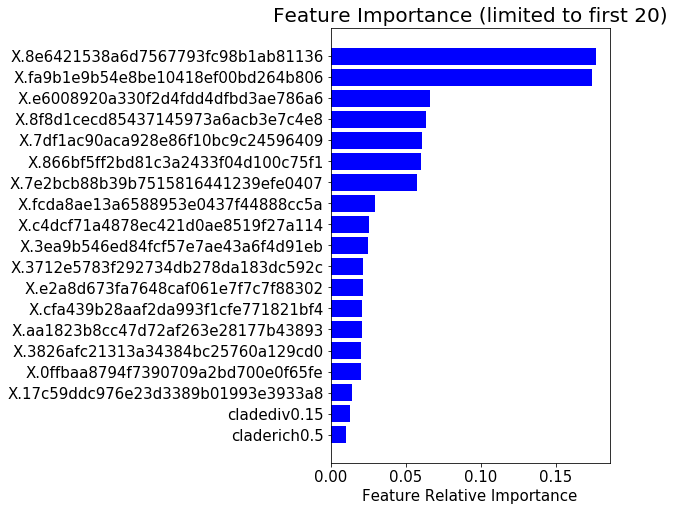

In [68]:
rf_comb_5 = RandomForestRegressor(random_state=2)
train_comb_pred5, val_comb_pred5, importances5, rf_comb_5 = \
    ml.rf_fit(rf_comb_5, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param, fs=(5, 8))

In [69]:
train_comb_pred_rs5, val_comb_pred_rs5, estimators_comb_rs5, param_comb_rs5 = \
    ml.random_search(rf_comb_5, tuning, xtrain_d, ytrain_d, xval_d, yval_d, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.09254084638073272
RMSE for validation set: 0.30961363761063593


# Dimension Reduction

## Manually Selected

In [70]:
meta_selected = \
['claderich0.1',
 'cladediv0.1',
 'cladediv0.4',
 'claderich0.8']

taxa_selected = \
[
'X.fa9b1e9b54e8be10418ef00bd264b806',##
'X.9a863767b07b7bf310cc785fb3253e96',
'X.6551fb3be9725c2f0d631e119b22c331',##    
'X.3ae6035cfbb5524a0af4bf8aa642aa11',    
'X.2dc979021700537831de37f56a782f17',    
'X.3826afc21313a34384bc25760a129cd0',##    
'X.f60d1b84853b19fa59e9f6d208e16d96',    
'X.8e6421538a6d7567793fc98b1ab81136',##   
'X.9e86efdb265fbda2a17f93a3ab66ac2f',   
'X.b3be059be813012cffa0ce669d10b3c4', 
'X.e6008920a330f2d4fdd4dfbd3ae786a6',##
'X.1dfe3eac7261d34a2ac811ef43971b7d',##
'X.c32df6f5d518885f8849b953f2e018b6'    
]

In [71]:
# Warning: clean_selected, y (disease score) is before transformation
clean_selected = pd.concat([total.Experiment, clean[meta_selected], clean[taxa_selected]], axis=1)
cor_df = pd.concat([clean_selected.reset_index(), y], axis=1)
cor_df = cor_df.set_index('FieldID')

In [72]:
cor_df.columns.values[-1] = 'disease_severity'
cor_df = cor_df.rename(columns = {'disease_severity':'disease_severity'})
selected_trans = cor_df.copy()
selected_trans = selected_trans.drop(['Experiment'], axis=1)
selected_trans, mu_selected, sd_selected = Utils.normalization(selected_trans)
selected_trans = pd.concat([X_taxa.Experiment, selected_trans], axis=1)  # concat experiment 0/1 indicator
selected_trans = pd.concat([selected_trans.reset_index(), yt_disease], axis=1)  # concat johnson_transform y
selected_trans = selected_trans.set_index('FieldID')
selected_trans.columns.values[-1] = 'disease_transform'
selected_trans = selected_trans.rename(columns = {'disease_transform':'disease_transform'})
selected_trans.tail(2)

,Experiment,claderich0.1,cladediv0.1,cladediv0.4,claderich0.8,X.fa9b1e9b54e8be10418ef00bd264b806,X.9a863767b07b7bf310cc785fb3253e96,X.6551fb3be9725c2f0d631e119b22c331,X.3ae6035cfbb5524a0af4bf8aa642aa11,X.2dc979021700537831de37f56a782f17,X.3826afc21313a34384bc25760a129cd0,X.f60d1b84853b19fa59e9f6d208e16d96,X.8e6421538a6d7567793fc98b1ab81136,X.9e86efdb265fbda2a17f93a3ab66ac2f,X.b3be059be813012cffa0ce669d10b3c4,X.e6008920a330f2d4fdd4dfbd3ae786a6,X.1dfe3eac7261d34a2ac811ef43971b7d,X.c32df6f5d518885f8849b953f2e018b6,disease_severity,disease_transform
FieldID,,,,,,,,,,,,,,,,,,,,
41,1,0.318043,-0.607624,0.683326,0.400150,-0.656285,-0.470743,-0.368436,-0.293188,-0.352591,0.560934,-0.202122,-0.391070,-0.476785,-0.378889,-0.64082,0.396515,4.430830,-0.108882,0.142125
42,1,1.453018,2.253805,1.761641,2.791948,-0.656285,-0.470743,-0.746568,-0.293188,-0.352591,-0.621576,-0.049798,0.805145,-0.476785,-0.378889,-0.64082,-0.350542,-0.422655,-1.166365,-1.605319


In [73]:
selected_trans = selected_trans.drop(['disease_severity', 'disease_transform'], axis=1)
selected_trans.tail(2)

,Experiment,claderich0.1,cladediv0.1,cladediv0.4,claderich0.8,X.fa9b1e9b54e8be10418ef00bd264b806,X.9a863767b07b7bf310cc785fb3253e96,X.6551fb3be9725c2f0d631e119b22c331,X.3ae6035cfbb5524a0af4bf8aa642aa11,X.2dc979021700537831de37f56a782f17,X.3826afc21313a34384bc25760a129cd0,X.f60d1b84853b19fa59e9f6d208e16d96,X.8e6421538a6d7567793fc98b1ab81136,X.9e86efdb265fbda2a17f93a3ab66ac2f,X.b3be059be813012cffa0ce669d10b3c4,X.e6008920a330f2d4fdd4dfbd3ae786a6,X.1dfe3eac7261d34a2ac811ef43971b7d,X.c32df6f5d518885f8849b953f2e018b6
FieldID,,,,,,,,,,,,,,,,,,
41,1,0.318043,-0.607624,0.683326,0.400150,-0.656285,-0.470743,-0.368436,-0.293188,-0.352591,0.560934,-0.202122,-0.391070,-0.476785,-0.378889,-0.64082,0.396515,4.430830
42,1,1.453018,2.253805,1.761641,2.791948,-0.656285,-0.470743,-0.746568,-0.293188,-0.352591,-0.621576,-0.049798,0.805145,-0.476785,-0.378889,-0.64082,-0.350542,-0.422655


In [74]:
selected_trans.shape

(26, 18)

In [75]:
xtrain_manual, xval_manual, ytrain_manual, yval_manual = train_test_split(selected_trans, yt, test_size = 0.2, random_state = 1)
print(xval_manual.iloc[:, :4], end="\n\n")
print(yval_manual)

         Experiment  claderich0.1  cladediv0.1  cladediv0.4
FieldID                                                    
32                1      1.939437     1.238745     1.494086
27                1      1.453018    -0.000250     0.807886
31                1      1.290879     0.828124     1.175163
4                 0     -0.979072    -1.608700    -1.180598
38                1      1.453018     1.249896     1.032106
11                0     -1.303351    -1.145145    -0.868549

FieldID
32   -1.605319
27    1.424344
31   -0.252561
4     1.195968
38   -1.605319
11   -0.339759
Name: diffCSscore, dtype: float64


C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.06105326659778237
RMSE for validation set: 0.33743981883519814


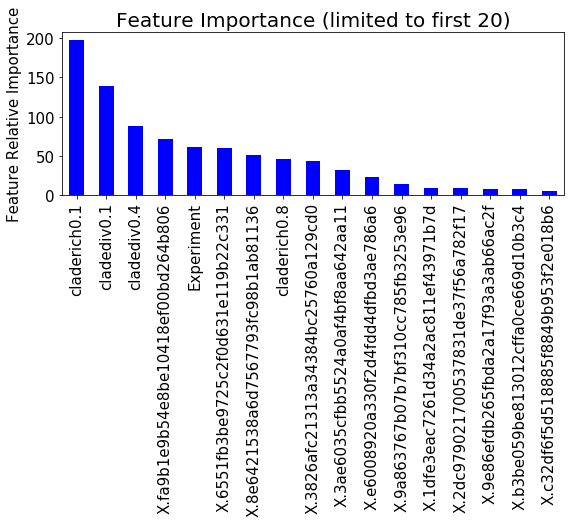

In [120]:
xgb_select1 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_select_pred1, val_select_pred1, top_select_1 = \
    ml.xgb_fit(xgb_select1, xtrain_manual, ytrain_manual, xval_manual, yval_manual, cv_folds=4, trans_param=trans_param)

'X.f60d1b84853b19fa59e9f6d208e16d96' is missing

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.0978368661391326
RMSE for validation set: 0.32511153537586596


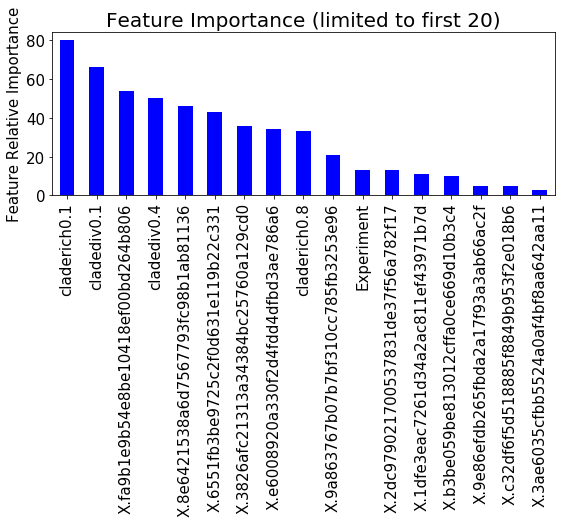

In [121]:
xgb_select2 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_select_pred2, val_select_pred2, top_select_2 = \
    ml.xgb_fit(xgb_select2, xtrain_manual, ytrain_manual, xval_manual, yval_manual, cv_folds=4, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1500632505525481
RMSE for validation set: 0.313743277589521


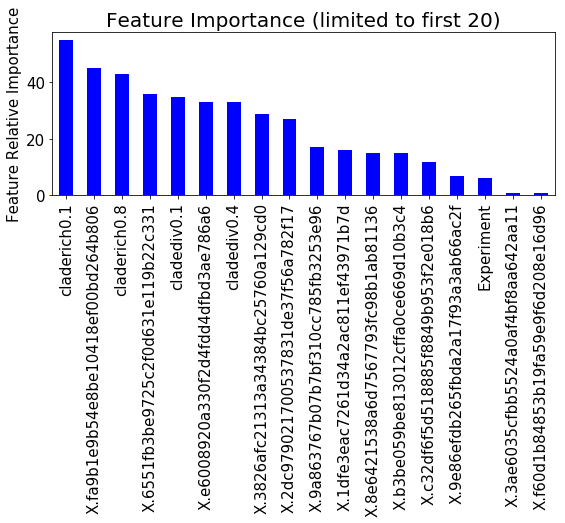

In [122]:
xgb_select3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_select_pred3, val_select_pred3, top_select_3 = \
    ml.xgb_fit(xgb_select3, xtrain_manual, ytrain_manual, xval_manual, yval_manual, cv_folds=4, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.16207456729865702
RMSE for validation set: 0.31206501795296104


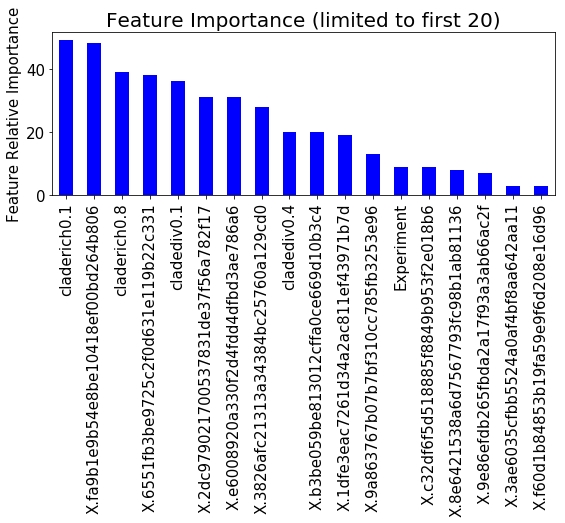

In [123]:
xgb_select4 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=7,
    seed=2)
train_select_pred4, val_select_pred4, top_select_4 = \
    ml.xgb_fit(xgb_select4, xtrain_manual, ytrain_manual, xval_manual, yval_manual, cv_folds=4, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.17351007622467718
RMSE for validation set: 0.3110823549338284


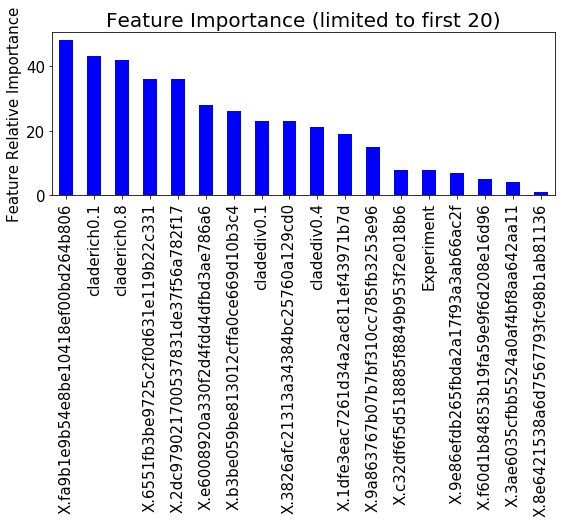

In [124]:
xgb_select5 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_select_pred5, val_select_pred5, top_select_5 = \
    ml.xgb_fit(xgb_select5, xtrain_manual, ytrain_manual, xval_manual, yval_manual, cv_folds=4, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.052166232183905065
RMSE for validation set: 0.3834167640772336


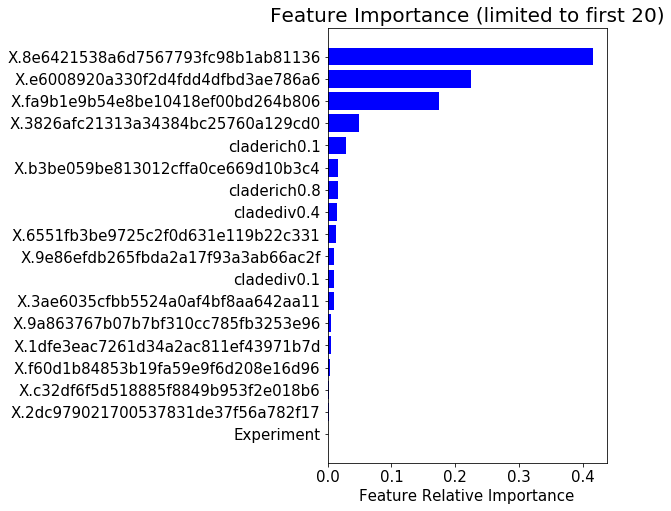

In [127]:
rf_select_6 = RandomForestRegressor(random_state=2)
train_select_pred6, val_select_pred6, importances6, rf_select_6 = \
    ml.rf_fit(rf_select_6, xtrain_manual, ytrain_manual, xval_manual, yval_manual, trans_param=trans_param, fs=(5, 8))

In [93]:
tuning_var = \
{'max_depth': [7, 10, 13, 15, 17, 21],
 'max_features': [5, 7, 10, 15],
 'min_samples_split': [2, 5, 7, 10],
 'n_estimators': [20, 50, 80, 100]}

In [94]:
train_select_pred_rs6, val_select_pred_rs6, estimators_select_rs6, param_select_rs6 = \
    ml.random_search(rf_select_6, tuning_var, xtrain_manual, ytrain_manual, xval_manual, yval_manual, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.054909921436835867
RMSE for validation set: 0.3313152562677138


## PCA

In [99]:
pca_df = total.drop(['Experiment'], axis=1)
pca_df.tail()

,claderich0.1,cladediv0.1,claderich0.15,cladediv0.15,claderich0.2,cladediv0.2,claderich0.25,cladediv0.25,claderich0.3,cladediv0.3,...,X.b21ace384dce2bee9979419021f280b7,X.b8e03ac481f6e7ad4c5bcae9d44ef0ee,X.bdd19e20552367f7068aae7443c1a878,X.dbeb232ebe90883462f226d519318954,X.e1f1df77139a409085c4139eb7ca3b76,X.f1c0ac2d6e23b055ade81be385d9a58d,X.f6234b004dc286131b767f4ba12d18a6,X.f659d34664f3724bfcafe3a0e6e3eaed,X.fa3f3f5e0b7451c8cae261c34053eb27,X.4092452cccf123b62ba6e23278b18e82
FieldID,,,,,,,,,,,,,,,,,,,,,
37,0.318043,0.435394,0.224503,0.345979,0.060739,0.265750,0.188307,0.375268,0.234007,0.211112,...,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116
38,1.453018,1.249896,0.887809,1.110383,1.054110,1.258637,0.975162,1.268684,0.845365,1.309132,...,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116
40,1.128740,1.763737,1.750106,1.706507,1.589003,1.740226,1.412303,1.887599,1.080503,1.554136,...,-0.196116,-0.196116,4.902903,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,4.902903
41,0.318043,-0.607624,0.357164,-0.626323,0.264507,-0.166793,0.221093,-0.128338,0.363333,0.434622,...,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116,-0.196116
42,1.453018,2.253805,2.347081,2.192168,2.913498,2.025831,3.117154,2.120866,2.838156,1.835707,...,-0.196116,-0.196116,-0.196116,4.902903,-0.196116,4.902903,4.902903,4.902903,4.902903,-0.196116


In [98]:
from sklearn.decomposition import PCA

In [102]:
pca = PCA(n_components=0.95, whiten=True)  # keep 95% information
pca_result = pca.fit_transform(pca_df)
pca_result = pd.DataFrame(pca_result, index=total.index)
pca_result

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
FieldID,,,,,,,,,,,,,,,,,,,,,
1,-0.205786,-0.167102,-0.110213,0.020333,-0.203447,-0.467240,-0.712145,-0.132563,-0.670423,-0.332202,...,3.737916,2.707270,0.780684,-0.099356,0.483720,0.017730,0.113632,-0.436160,0.328580,-0.020738
2,-0.206208,-0.164542,-0.132905,0.014855,-0.193058,-0.433127,-0.649553,-0.092811,-0.527906,-0.238615,...,0.371659,-1.080803,-2.296988,3.441888,1.904683,-0.376764,0.168693,-0.668349,0.445659,0.041177
3,-0.213295,-0.155382,-0.126901,0.002007,-0.195482,-0.455788,-0.663640,-0.087092,-0.578186,-0.226477,...,0.667722,-1.341527,-2.835554,-3.357487,0.131278,-0.119249,0.348626,-0.918741,0.473630,-0.029704
4,-0.212105,-0.149108,-0.136673,-0.017980,-0.172438,-0.385058,-0.548612,-0.076396,-0.373846,-0.145907,...,0.147661,-0.245167,-0.399929,-0.038826,-0.192816,0.581883,-0.004267,4.556301,1.345252,0.043336
5,-0.191528,-0.150346,-0.079792,0.059604,-0.117677,-0.370705,-0.443335,-0.051804,-0.357575,-0.147879,...,-0.152149,-0.205412,0.211876,0.130060,-0.401945,-0.060053,-0.277231,0.118929,-1.271567,-0.626956
6,-0.203996,-0.164923,-0.111606,0.010226,-0.138231,-0.382059,-0.452559,-0.053215,-0.366863,-0.156761,...,-0.117353,-0.250611,0.235660,0.055073,-0.526825,-0.069482,-0.308622,0.120562,-1.981153,4.250400
7,-0.187692,-0.156783,-0.100092,0.037275,-0.114402,-0.369350,-0.420544,-0.045409,-0.348654,-0.138389,...,-0.157248,-0.195674,0.196233,0.092350,-0.415519,-0.051217,-0.265486,0.124158,-0.965672,-0.502301
8,-0.186307,-0.166367,-0.105496,0.033078,-0.129479,-0.427920,-0.522491,-0.052134,-0.459966,-0.192940,...,-0.382948,-0.540558,0.834895,0.341960,-1.713226,-0.408454,-3.174677,-1.159747,2.689259,0.286802
9,-0.212208,-0.169440,-0.121806,-0.015187,-0.165118,-0.405956,-0.552766,-0.070737,-0.450609,-0.176639,...,-0.586324,-1.561614,2.906109,-0.989867,3.167659,-0.034159,0.577847,-0.282993,0.700241,0.077981


In [103]:
pca_95 = pd.concat([total.Experiment, pca_result], axis=1)
pca_95

,Experiment,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
FieldID,,,,,,,,,,,,,,,,,,,,,
1,0,-0.205786,-0.167102,-0.110213,0.020333,-0.203447,-0.467240,-0.712145,-0.132563,-0.670423,...,3.737916,2.707270,0.780684,-0.099356,0.483720,0.017730,0.113632,-0.436160,0.328580,-0.020738
2,0,-0.206208,-0.164542,-0.132905,0.014855,-0.193058,-0.433127,-0.649553,-0.092811,-0.527906,...,0.371659,-1.080803,-2.296988,3.441888,1.904683,-0.376764,0.168693,-0.668349,0.445659,0.041177
3,0,-0.213295,-0.155382,-0.126901,0.002007,-0.195482,-0.455788,-0.663640,-0.087092,-0.578186,...,0.667722,-1.341527,-2.835554,-3.357487,0.131278,-0.119249,0.348626,-0.918741,0.473630,-0.029704
4,0,-0.212105,-0.149108,-0.136673,-0.017980,-0.172438,-0.385058,-0.548612,-0.076396,-0.373846,...,0.147661,-0.245167,-0.399929,-0.038826,-0.192816,0.581883,-0.004267,4.556301,1.345252,0.043336
5,0,-0.191528,-0.150346,-0.079792,0.059604,-0.117677,-0.370705,-0.443335,-0.051804,-0.357575,...,-0.152149,-0.205412,0.211876,0.130060,-0.401945,-0.060053,-0.277231,0.118929,-1.271567,-0.626956
6,0,-0.203996,-0.164923,-0.111606,0.010226,-0.138231,-0.382059,-0.452559,-0.053215,-0.366863,...,-0.117353,-0.250611,0.235660,0.055073,-0.526825,-0.069482,-0.308622,0.120562,-1.981153,4.250400
7,0,-0.187692,-0.156783,-0.100092,0.037275,-0.114402,-0.369350,-0.420544,-0.045409,-0.348654,...,-0.157248,-0.195674,0.196233,0.092350,-0.415519,-0.051217,-0.265486,0.124158,-0.965672,-0.502301
8,0,-0.186307,-0.166367,-0.105496,0.033078,-0.129479,-0.427920,-0.522491,-0.052134,-0.459966,...,-0.382948,-0.540558,0.834895,0.341960,-1.713226,-0.408454,-3.174677,-1.159747,2.689259,0.286802
9,0,-0.212208,-0.169440,-0.121806,-0.015187,-0.165118,-0.405956,-0.552766,-0.070737,-0.450609,...,-0.586324,-1.561614,2.906109,-0.989867,3.167659,-0.034159,0.577847,-0.282993,0.700241,0.077981


In [104]:
xtrain_pca, xval_pca, ytrain_pca, yval_pca = train_test_split(pca_95, yt, test_size=0.2, random_state=1)
print(xval_pca.iloc[:, :4], end="\n\n")
print(yval_pca)

         Experiment         0         1         2
FieldID                                          
32                1  0.165234  4.866494  0.158059
27                1 -0.091999 -0.431870  4.790563
31                1 -0.258946 -0.065193 -0.583622
4                 0 -0.212105 -0.149108 -0.136673
38                1 -0.266164 -0.210769 -0.414306
11                0 -0.194094 -0.164652 -0.102288

FieldID
32   -1.605319
27    1.424344
31   -0.252561
4     1.195968
38   -1.605319
11   -0.339759
Name: diffCSscore, dtype: float64


In [119]:
ytrain_pca.values

array([-1.60531853, -0.23016393,  0.81440047, -0.15492751,  0.84207123,
        0.74477762,  0.0938001 , -0.36950107, -1.60531853, -0.48676314,
       -0.40976007,  0.01514223,  0.32612388, -1.60531853,  0.14212494,
        0.73227388,  1.31231414,  2.07543109,  0.27980283,  0.30320504])

In [106]:
xtrain_pca.shape, xval_pca.shape, ytrain_pca.shape, yval_pca.shape

((20, 22), (6, 22), (20,), (6,))

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.20430788796824007
RMSE for validation set: 0.33905234456152783


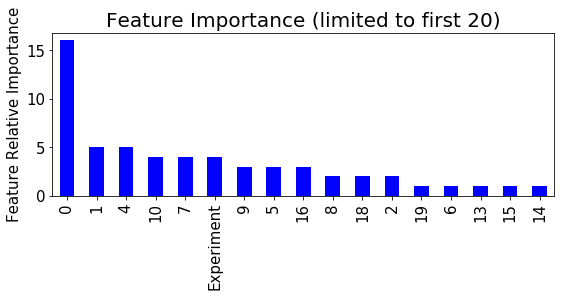

In [142]:
xgb_pca_1 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=0,
    seed=2)
train_pca_pred1, val_pca_pred1, top_pca1 = \
    ml.xgb_fit(xgb_pca_1, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.10205152658360497
RMSE for validation set: 0.34435913476802793


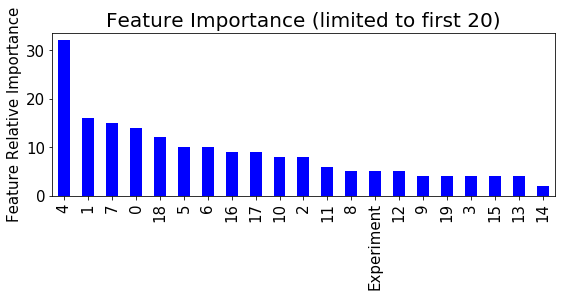

In [143]:
xgb_pca_2 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_pca_pred2, val_pca_pred2, top_pca2 = \
    ml.xgb_fit(xgb_pca_2, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.13643572585138897
RMSE for validation set: 0.32728974570543984


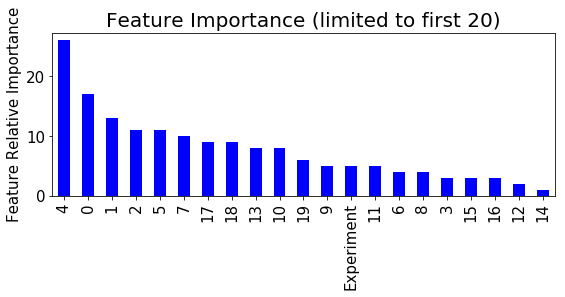

In [144]:
xgb_pca_3 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=3,
    seed=2)
train_pca_pred3, val_pca_pred3, top_pca3 = \
    ml.xgb_fit(xgb_pca_3, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.14890890234313442
RMSE for validation set: 0.31121954135391106


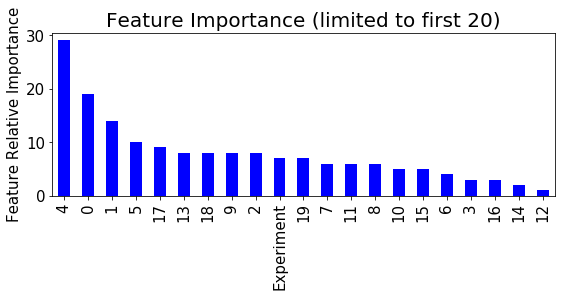

In [146]:
xgb_pca_4 = XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_pca_pred4, val_pca_pred4, top_pca4 = \
    ml.xgb_fit(xgb_pca_4, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1527928844965562
RMSE for validation set: 0.31731815826007986


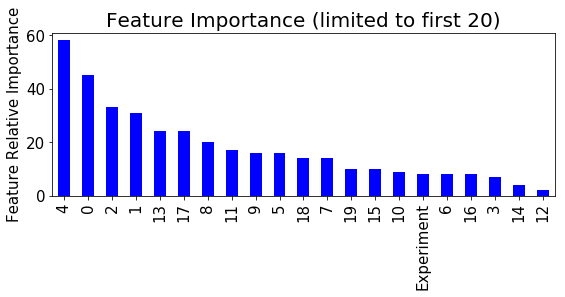

In [147]:
xgb_pca_5 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_pca_pred5, val_pca_pred5, top_pca5 = \
    ml.xgb_fit(xgb_pca_5, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.17698106895560567
RMSE for validation set: 0.31288662132186995


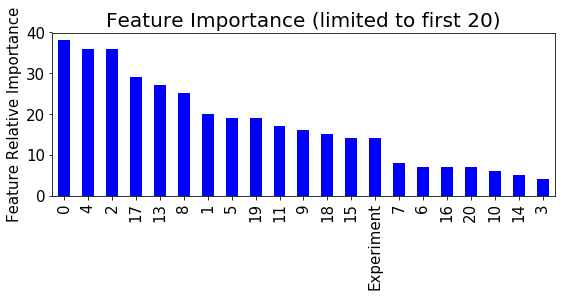

In [155]:
xgb_pca_6 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_pca_pred6, val_pca_pred6, top_pca6 = \
    ml.xgb_fit(xgb_pca_6, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.09417683825968302
RMSE for validation set: 0.3546941846540437


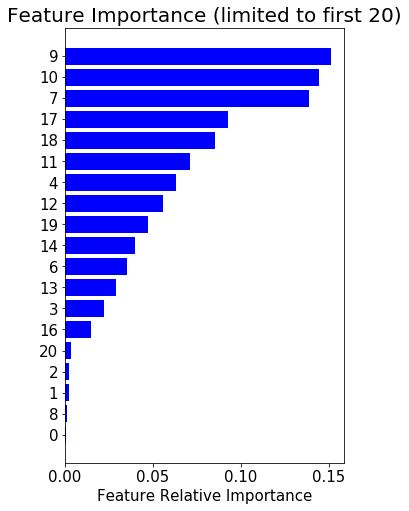

In [130]:
rf_pca7 = RandomForestRegressor(random_state=2)
train_pca_pred7, val_pca_pred7, importances_pca7, rf_pca7 = \
    ml.rf_fit(rf_pca7, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param, fs=(5, 8))

In [132]:
train_pca_pred_rs7, val_pca_pred_rs7, estimators_pca_rs7, param_pca_rs7 = \
    ml.random_search(rf_pca7, tuning_var, xtrain_pca, ytrain_pca, xval_pca, yval_pca, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.11720718868305466
RMSE for validation set: 0.32553202283312954


In [156]:
pca2 = PCA(n_components=0.85, whiten=True)  # keep 85% information
pca_result2 = pca2.fit_transform(pca_df)
pca_result2 = pd.DataFrame(pca_result, index=total.index)
pca_result2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
FieldID,,,,,,,,,,,,,,,,,,,,,
1,-0.205786,-0.167102,-0.110213,0.020333,-0.203447,-0.467240,-0.712145,-0.132563,-0.670423,-0.332202,...,3.737916,2.707270,0.780684,-0.099356,0.483720,0.017730,0.113632,-0.436160,0.328580,-0.020738
2,-0.206208,-0.164542,-0.132905,0.014855,-0.193058,-0.433127,-0.649553,-0.092811,-0.527906,-0.238615,...,0.371659,-1.080803,-2.296988,3.441888,1.904683,-0.376764,0.168693,-0.668349,0.445659,0.041177
3,-0.213295,-0.155382,-0.126901,0.002007,-0.195482,-0.455788,-0.663640,-0.087092,-0.578186,-0.226477,...,0.667722,-1.341527,-2.835554,-3.357487,0.131278,-0.119249,0.348626,-0.918741,0.473630,-0.029704
4,-0.212105,-0.149108,-0.136673,-0.017980,-0.172438,-0.385058,-0.548612,-0.076396,-0.373846,-0.145907,...,0.147661,-0.245167,-0.399929,-0.038826,-0.192816,0.581883,-0.004267,4.556301,1.345252,0.043336
5,-0.191528,-0.150346,-0.079792,0.059604,-0.117677,-0.370705,-0.443335,-0.051804,-0.357575,-0.147879,...,-0.152149,-0.205412,0.211876,0.130060,-0.401945,-0.060053,-0.277231,0.118929,-1.271567,-0.626956
6,-0.203996,-0.164923,-0.111606,0.010226,-0.138231,-0.382059,-0.452559,-0.053215,-0.366863,-0.156761,...,-0.117353,-0.250611,0.235660,0.055073,-0.526825,-0.069482,-0.308622,0.120562,-1.981153,4.250400
7,-0.187692,-0.156783,-0.100092,0.037275,-0.114402,-0.369350,-0.420544,-0.045409,-0.348654,-0.138389,...,-0.157248,-0.195674,0.196233,0.092350,-0.415519,-0.051217,-0.265486,0.124158,-0.965672,-0.502301
8,-0.186307,-0.166367,-0.105496,0.033078,-0.129479,-0.427920,-0.522491,-0.052134,-0.459966,-0.192940,...,-0.382948,-0.540558,0.834895,0.341960,-1.713226,-0.408454,-3.174677,-1.159747,2.689259,0.286802
9,-0.212208,-0.169440,-0.121806,-0.015187,-0.165118,-0.405956,-0.552766,-0.070737,-0.450609,-0.176639,...,-0.586324,-1.561614,2.906109,-0.989867,3.167659,-0.034159,0.577847,-0.282993,0.700241,0.077981


In [157]:
pca_85 = pd.concat([total.Experiment, pca_result2], axis=1)
pca_85

,Experiment,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
FieldID,,,,,,,,,,,,,,,,,,,,,
1,0,-0.205786,-0.167102,-0.110213,0.020333,-0.203447,-0.467240,-0.712145,-0.132563,-0.670423,...,3.737916,2.707270,0.780684,-0.099356,0.483720,0.017730,0.113632,-0.436160,0.328580,-0.020738
2,0,-0.206208,-0.164542,-0.132905,0.014855,-0.193058,-0.433127,-0.649553,-0.092811,-0.527906,...,0.371659,-1.080803,-2.296988,3.441888,1.904683,-0.376764,0.168693,-0.668349,0.445659,0.041177
3,0,-0.213295,-0.155382,-0.126901,0.002007,-0.195482,-0.455788,-0.663640,-0.087092,-0.578186,...,0.667722,-1.341527,-2.835554,-3.357487,0.131278,-0.119249,0.348626,-0.918741,0.473630,-0.029704
4,0,-0.212105,-0.149108,-0.136673,-0.017980,-0.172438,-0.385058,-0.548612,-0.076396,-0.373846,...,0.147661,-0.245167,-0.399929,-0.038826,-0.192816,0.581883,-0.004267,4.556301,1.345252,0.043336
5,0,-0.191528,-0.150346,-0.079792,0.059604,-0.117677,-0.370705,-0.443335,-0.051804,-0.357575,...,-0.152149,-0.205412,0.211876,0.130060,-0.401945,-0.060053,-0.277231,0.118929,-1.271567,-0.626956
6,0,-0.203996,-0.164923,-0.111606,0.010226,-0.138231,-0.382059,-0.452559,-0.053215,-0.366863,...,-0.117353,-0.250611,0.235660,0.055073,-0.526825,-0.069482,-0.308622,0.120562,-1.981153,4.250400
7,0,-0.187692,-0.156783,-0.100092,0.037275,-0.114402,-0.369350,-0.420544,-0.045409,-0.348654,...,-0.157248,-0.195674,0.196233,0.092350,-0.415519,-0.051217,-0.265486,0.124158,-0.965672,-0.502301
8,0,-0.186307,-0.166367,-0.105496,0.033078,-0.129479,-0.427920,-0.522491,-0.052134,-0.459966,...,-0.382948,-0.540558,0.834895,0.341960,-1.713226,-0.408454,-3.174677,-1.159747,2.689259,0.286802
9,0,-0.212208,-0.169440,-0.121806,-0.015187,-0.165118,-0.405956,-0.552766,-0.070737,-0.450609,...,-0.586324,-1.561614,2.906109,-0.989867,3.167659,-0.034159,0.577847,-0.282993,0.700241,0.077981


In [158]:
xtrain_pca2, xval_pca2, ytrain_pca, yval_pca = train_test_split(pca_85, yt, test_size=0.2, random_state=1)
print(xval_pca2.iloc[:, :4], end="\n\n")
print(yval_pca)

         Experiment         0         1         2
FieldID                                          
32                1  0.165234  4.866494  0.158059
27                1 -0.091999 -0.431870  4.790563
31                1 -0.258946 -0.065193 -0.583622
4                 0 -0.212105 -0.149108 -0.136673
38                1 -0.266164 -0.210769 -0.414306
11                0 -0.194094 -0.164652 -0.102288

FieldID
32   -1.605319
27    1.424344
31   -0.252561
4     1.195968
38   -1.605319
11   -0.339759
Name: diffCSscore, dtype: float64


C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.10050489585330843
RMSE for validation set: 0.3524053227526433


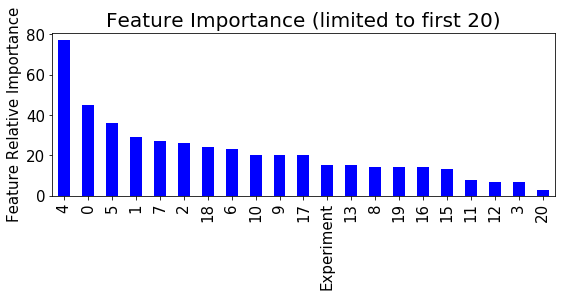

In [159]:
xgb_pca_10 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_pca_pred10, val_pca_pred10, top_pca10 = \
    ml.xgb_fit(xgb_pca_10, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.1527928844965562
RMSE for validation set: 0.31731815826007986


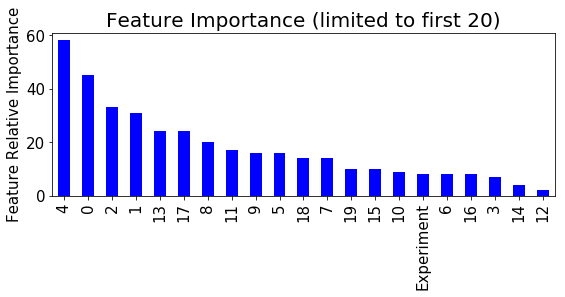

In [160]:
xgb_pca_11 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_pca_pred11, val_pca_pred11, top_pca11 = \
    ml.xgb_fit(xgb_pca_11, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.17698106895560567
RMSE for validation set: 0.31288662132186995


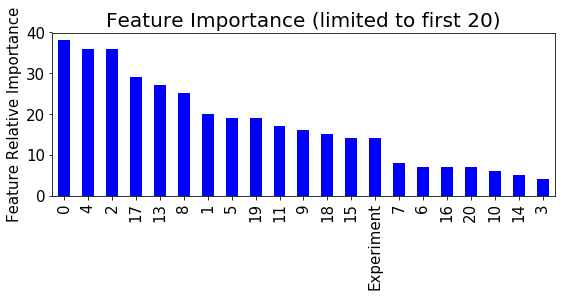

In [161]:
xgb_pca_12 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_pca_pred12, val_pca_pred12, top_pca12 = \
    ml.xgb_fit(xgb_pca_12, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.19060401349202807
RMSE for validation set: 0.3150736017684576


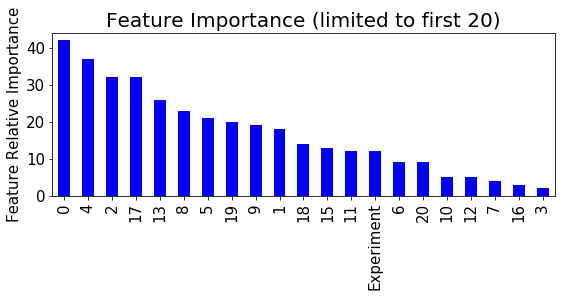

In [162]:
xgb_pca_13 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=15,
    seed=2)
train_pca_pred13, val_pca_pred13, top_pca13 = \
    ml.xgb_fit(xgb_pca_13, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.09417683825968302
RMSE for validation set: 0.3546941846540437


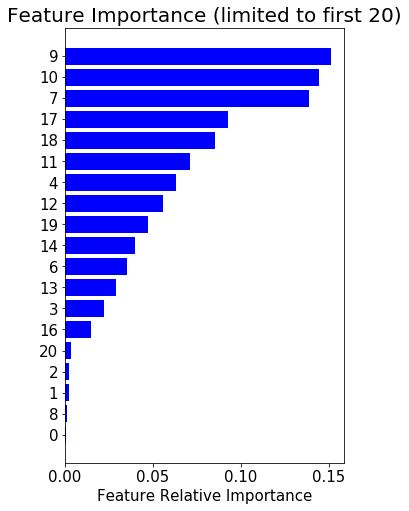

In [163]:
rf_pca17 = RandomForestRegressor(random_state=2)
train_pca_pred17, val_pca_pred17, importances_pca17, rf_pca17 = \
    ml.rf_fit(rf_pca17, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param, fs=(5, 8))

In [164]:
train_pca_pred_rs17, val_pca_pred_rs17, estimators_pca_rs17, param_pca_rs17 = \
    ml.random_search(rf_pca17, tuning_var, xtrain_pca2, ytrain_pca, xval_pca2, yval_pca, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.11720718868305466
RMSE for validation set: 0.32553202283312954


## Keras Auto Encoder

Reference  
- https://statcompute.wordpress.com/2017/01/15/autoencoder-for-dimensionality-reduction/  
- https://keras.io/optimizers/  
- https://blog.keras.io/building-autoencoders-in-keras.html  
- https://www.kaggle.com/saivarunk/dimensionality-reduction-using-keras-auto-encoder

In [165]:
from sklearn.preprocessing import minmax_scale
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [168]:
clean_scale = pd.DataFrame(minmax_scale(clean, axis = 0), index=total.index)
clean_scale = pd.concat([total.Experiment, clean_scale], axis=1)
clean_scale

C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  """Entry point for launching an IPython kernel.


,Experiment,0,1,2,3,4,5,6,7,8,...,9910,9911,9912,9913,9914,9915,9916,9917,9918,9919
FieldID,,,,,,,,,,,,,,,,,,,,,
1,0,0.227273,0.231059,0.236364,0.335768,0.183544,0.239897,0.162304,0.174202,0.143288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.136364,0.128069,0.090909,0.122448,0.069620,0.128386,0.123037,0.168113,0.134238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.227273,0.000000,0.218182,0.019894,0.120253,0.000000,0.136126,0.000000,0.128205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.181818,0.038236,0.072727,0.000000,0.069620,0.007474,0.065445,0.006055,0.096531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.227273,0.599231,0.072727,0.514859,0.088608,0.502297,0.052356,0.307862,0.036199,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0,0.409091,0.593475,0.200000,0.601376,0.145570,0.536635,0.078534,0.327937,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.000000,0.214204,0.000000,0.368988,0.000000,0.255969,0.000000,0.152536,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.272727,0.403557,0.218182,0.433461,0.120253,0.475845,0.091623,0.433696,0.069382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0.500000,0.267641,0.272727,0.390988,0.189873,0.439060,0.146597,0.342166,0.155354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. Compared to Adagrad, in the original version of Adadelta you don't have to set an initial learning rate.
In this version, initial learning rate and decay factor can be set, as in most other Keras optimizers.

In [178]:
ncol = clean_scale.shape[1]
xTrain_clean, xVal_clean, yTrain, yVal = train_test_split(clean_scale, yt, train_size=0.8, random_state=1)
 
### AN EXAMPLE OF SIMPLE AUTOENCODER ###
# InputLayer (None, 10)
#      Dense (None, 5)
#      Dense (None, 10)
 
input_dim = Input(shape = (ncol, ))
# DEFINE THE DIMENSION OF ENCODER
encoding_dim = 16
# DEFINE THE ENCODER LAYER
encoded = Dense(encoding_dim, activation = 'relu')(input_dim)
# DEFINE THE DECODER LAYER
decoded = Dense(ncol, activation = 'sigmoid')(encoded)
# COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
autoencoder = Model(input=input_dim, output=decoded)
# CONFIGURE AND TRAIN THE AUTOENCODER
autoencoder.compile(optimizer = 'adadelta', loss = 'mean_squared_error')
autoencoder.fit(xTrain_clean, xTrain_clean, nb_epoch = 50, batch_size = 100, shuffle = True)
# THE ENCODER TO EXTRACT THE REDUCED DIMENSION FROM THE ABOVE AUTOENCODER
encoder = Model(input = input_dim, output = encoded)
encoded_input = Input(shape = (encoding_dim, ))

C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/50
20/20 [==============================] - 0s 21ms/step - loss: 0.2464
Epoch 2/50
20/20 [==============================] - 0s 549us/step - loss: 0.2464
Epoch 3/50
20/20 [==============================] - 0s 598us/step - loss: 0.2463
Epoch 4/50
20/20 [==============================] - 0s 648us/step - loss: 0.2463
Epoch 5/50
20/20 [==============================] - 0s 549us/step - loss: 0.2463
Epoch 6/50
20/20 [==============================] - 0s 549us/step - loss: 0.2463
Epoch 7/50
20/20 [==============================] - 0s 598us/step - loss: 0.2463
Epoch 8/50
20/20 [==============================] - 0s 598us/step - loss: 0.2463
Epoch 9/50
20/20 [==============================] - 0s 648us/step - loss: 0.2463
Epoch 10/50
20/20 [==============================] - 0s 599us/step - loss: 0.2463
Epoch 11/50
20/20 [==============================] - 0s 649us/step - loss: 0.2463
Epoch 12/50
20/20 [==============================] - 0s 798us/step - loss: 0.2463
Epoch 13/50
20/20 [=======

C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [179]:
xTrain_autoencoding = encoder.predict(xTrain_clean)
xVal_autoencoding = encoder.predict(xVal_clean)

In [180]:
xTrain_autoencoding.shape

(20, 16)

In [184]:
xTrain_autoencoding = pd.DataFrame(xTrain_autoencoding)
xVal_autoencoding = pd.DataFrame(xVal_autoencoding)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.19005136463571234
RMSE for validation set: 0.3323350052743566


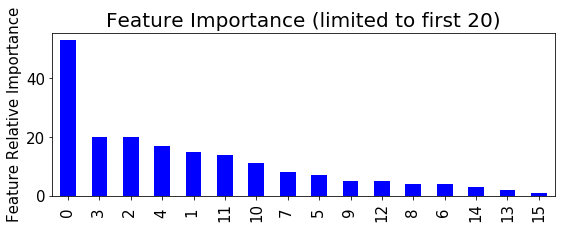

In [185]:
xgb_ae_1 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=2)
train_ae_pred1, val_ae_pred1, top_ae_1 = \
    ml.xgb_fit(xgb_ae_1, xTrain_autoencoding, ytrain_taxa_d, xVal_autoencoding, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.15662500615119995
RMSE for validation set: 0.33473230140708327


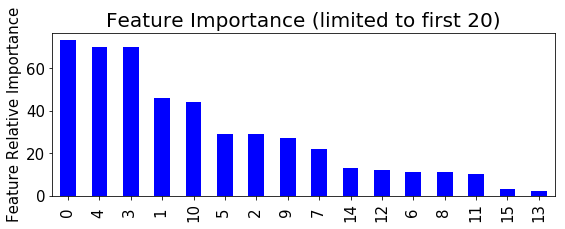

In [186]:
xgb_ae_2 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=5,
    seed=2)
train_ae_pred2, val_ae_pred2, top_ae_2 = \
    ml.xgb_fit(xgb_ae_2, xTrain_autoencoding, ytrain_taxa_d, xVal_autoencoding, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\xgboost-0.90-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



XGBoost Model Report
RMSE for traning set: 0.18243923476315613
RMSE for validation set: 0.33470810643942617


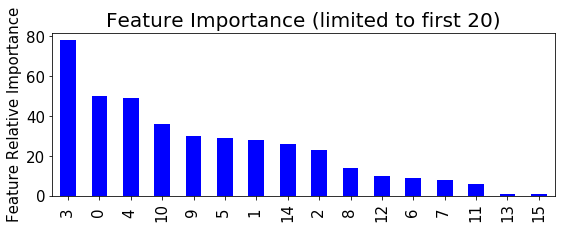

In [187]:
xgb_ae_3 = XGBRegressor(
    learning_rate=0.02,
    n_estimators=80,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    scale_pos_weight=1,
    reg_lambda=10,
    seed=2)
train_ae_pred3, val_ae_pred3, top_ae_3 = \
    ml.xgb_fit(xgb_ae_3, xTrain_autoencoding, ytrain_taxa_d, xVal_autoencoding, yval_taxa_d, trans_param=trans_param)

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest Model Report
RMSE for traning set: 0.11621321395760109
RMSE for validation set: 0.3446104557163276


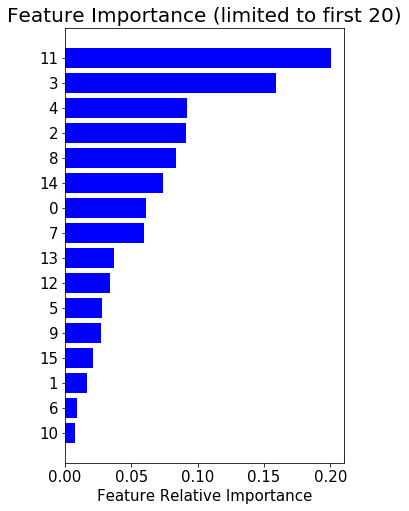

In [188]:
rf_ae_4 = RandomForestRegressor(random_state=2)
train_ae_pred4, val_ae_pred4, importances_ae4, rf_ae_4 = \
    ml.rf_fit(rf_ae_4, xTrain_autoencoding, ytrain_taxa_d, xVal_autoencoding, yval_taxa_d, trans_param=trans_param, fs=(5, 8))

In [190]:
train_ae_pred_rs4, val_ae_pred_rs4, estimators_ae_rs4, param_ae_rs4 = \
    ml.random_search(rf_ae_4, tuning_var, xTrain_autoencoding, ytrain_taxa_d, xVal_autoencoding, yval_taxa_d, trans_param=trans_param, cv=4)


Randomized Search Tuning Report
RMSE for traning set: 0.09261199719274614
RMSE for validation set: 0.32179383579540927


Dimension Reduction does not work as expected. 